In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

import pandas as pd
import numpy as np

from RoadDataset import RoadDataset

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
datasets_path = "../Jetson/autopilot/records/"
sub_dirs = os.listdir(datasets_path)
dataset_paths = [[datasets_path + sub_dir + "/" + sub_dir + ".csv", datasets_path + sub_dir + "/frames/"] for sub_dir in sub_dirs]
dataset_paths

[['../Jetson/autopilot/records/Sun Dec 27 17_46_56 2020/Sun Dec 27 17_46_56 2020.csv',
  '../Jetson/autopilot/records/Sun Dec 27 17_46_56 2020/frames/'],
 ['../Jetson/autopilot/records/Sun Dec 27 17_44_41 2020/Sun Dec 27 17_44_41 2020.csv',
  '../Jetson/autopilot/records/Sun Dec 27 17_44_41 2020/frames/']]

In [4]:
dataset_index = 0
column_names = ['filename','steering_wheel_angle','speed', 'blink_l', 'blink_r']
dataset = RoadDataset(dataset_paths[dataset_index][0], dataset_paths[dataset_index][1], column_names, batch_size=16)
dataset.clean()
dataset.balance()

Loaded dataset with 3775 samples
Cleaning dataset. Starting with 3775 samples.
Removing 1290 rows for reason: Low speed (< 25 km/h)
Removing 71 rows for reason: High SWA (> +90/ < -90 deg)
Removing 90 rows for reason: Left blinker on
Removing 182 rows for reason: Right blinker on
2142 samples remaining.
Balancing dataset. Starting with 2142 samples.
449 samples remaining.


In [5]:
#dataset.pairplot()

In [6]:
dataset.normalize()

In [7]:
#dataset.pairplot()

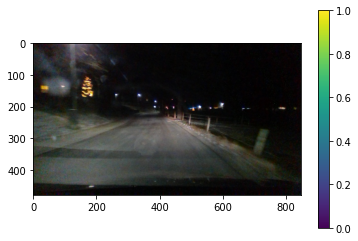

In [8]:
import matplotlib.pyplot as plt
image = dataset.get_batch_features(0)[0]/255
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Lambda

ch, row, col = 3, 480, 848

model = Sequential([
  Lambda(lambda x: x/127.5 - 1., input_shape=(row, col, ch), output_shape=(row, col, ch)),
  Conv2D(filters=8, kernel_size=(11,11), strides=(4,4), activation='relu'),
  #MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
  Conv2D(filters=16, kernel_size=(3,3), strides=(2, 2), activation='relu'),
  #MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
  Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), activation='relu'),
  #MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(1),
])
model.compile(optimizer='adam', loss='mse')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 480, 848, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 210, 8)       2912      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 104, 16)       1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 51, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 45696)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2924608   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [11]:
model.fit(dataset, epochs=10, verbose=1, use_multiprocessing=False, workers=1)

Epoch 1/10
28/28 [==============================] - 6s 230ms/step - loss: 3.1522
Epoch 2/10
28/28 [==============================] - 6s 230ms/step - loss: 0.1180
Epoch 3/10
28/28 [==============================] - 6s 230ms/step - loss: 0.0594
Epoch 4/10
28/28 [==============================] - 7s 237ms/step - loss: 0.0203
Epoch 5/10
28/28 [==============================] - 7s 235ms/step - loss: 0.0089
Epoch 6/10
28/28 [==============================] - 7s 235ms/step - loss: 0.0050
Epoch 7/10
28/28 [==============================] - 7s 234ms/step - loss: 0.0033
Epoch 8/10
28/28 [==============================] - 7s 233ms/step - loss: 0.0018
Epoch 9/10
28/28 [==============================] - 7s 237ms/step - loss: 0.0013
Epoch 10/10
28/28 [==============================] - 6s 230ms/step - loss: 0.0012


In [86]:
model_name = 'diypilot_v1'
model.save('./trained_models/' + model_name + '.h5')